# Implementacion Prophet a df_U_FR

1. [Carga del DataFrame](#carga-del-dataframe)
<br></br>
2. [Preparación del DataFrame para Procesar con Prophet](#preparación-del-dataframe-para-procesar-con-prophet)
<br></br>
2.1 [Fechas que Faltan](#fechas-que-faltan)
<br></br>
2.2 [Función que Genera el Número de Envíos para una Fecha que Falta](#funcion-que-genera-el-numero-de-envios-para-una-fecha-que-falta)
<br></br>
2.3 [Rellenado de Datos y Finalización](#rellenado-de-datos-y-finalizacion)
<br></br>
3. [Prophet](#prophet)
<br></br>
3.1 [Generación Predicción](#generacion-prediccion)
<br></br>
3.1 [Visualizaciones](#visualizaciones)
<br></br>
4. [RMSE](#rmse)
<br></br>
5. [Conclusiones](#conclusiones)


In [1]:
%load_ext watermark
%watermark

2019-06-11T07:36:54+02:00

CPython 3.6.8
IPython 6.2.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.13.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


## 1. <a id='carga-del-dataframe'>Carga del DataFrame</a>

In [2]:
import math
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
df_U_FR = pd.read_pickle('../Data/02.-Creacion-del-DataFrame-df_U_FR.pkl')

df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


Representamos gráficamente la evolución de los envíos del producto U en Francia.

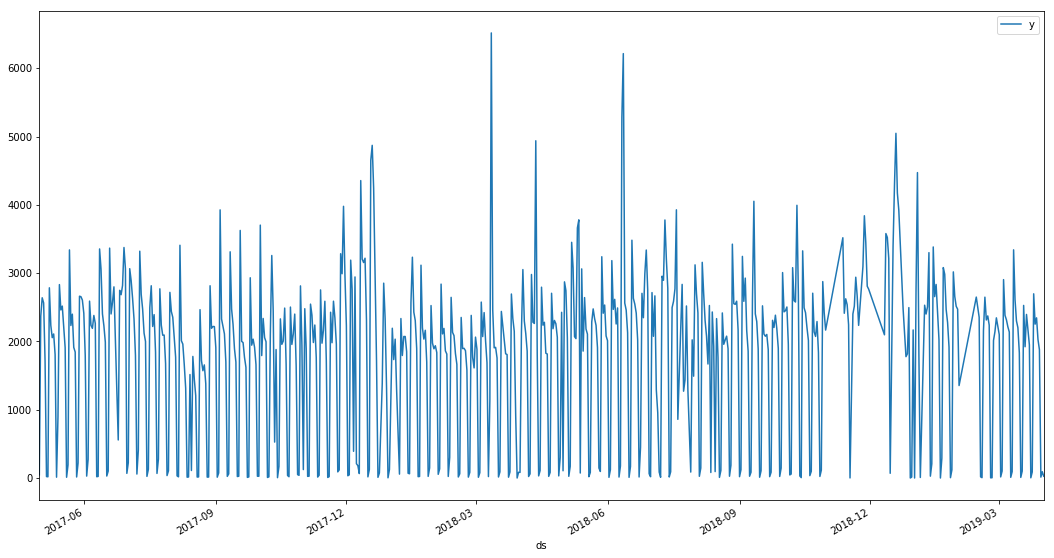

In [4]:
df_U_FR.plot.line(x = 'ds',y = 'y',figsize = (18,10));

## 2. <a id='preparación-del-dataframe-para-procesar-con-prophet'>Preparación del DataFrame para procesar con Prophet</a>



### 2.1 <a id='fechas-que-faltan'>Fechas que Faltan</a>

Los días que faltan en df_U_FR son:

In [5]:
missing_dates = pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_U_FR['ds'])

missing_dates

DatetimeIndex(['2017-06-24', '2017-12-25', '2018-01-01', '2018-01-06',
               '2018-07-21', '2018-07-22', '2018-07-28', '2018-11-01',
               '2018-11-02', '2018-11-03', '2018-11-04', '2018-11-05',
               '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09',
               '2018-11-10', '2018-11-11', '2018-11-18', '2018-11-24',
               '2018-11-25', '2018-12-01', '2018-12-02', '2018-12-03',
               '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07',
               '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-16',
               '2018-12-22', '2018-12-23', '2018-12-25', '2019-01-06',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12'],
              dtype='datetime64[ns]', freq=None)

In [6]:
len(missing_dates)

47

Son, por tanto, 47 días de los que no tenemos información.

### 2.2 <a id='funcion-que-genera-el-numero-de-envios-para-una-fecha-que-falta'>Función que Genera el Número de Envíos para una Fecha que Falta</a>

Para generar los valores de los días de los que no tenemos información, vamos a utilizar como referencia otros "día de la semana" de los que sí dispongamos de información. Por ejemplo, si no tenemos información de un martes, haremos la media de todos los martes de ese mes para generar el dato.

In [7]:
def new_y_for_date(date,df_temp):
    df_monthdays_for_date = df_temp.loc[(df_temp['ds'].dt.year == date.year) &
                                        (df_temp['ds'].dt.month == date.month) &
                                        (df_temp['ds'].dt.weekday == date.weekday())]
    new_y = df_monthdays_for_date['y'].mean()
    if np.isnan(new_y) == False:
        return np.int64(round(new_y))
    else:
        return np.int64(round(df_temp.loc[df_temp['ds'].dt.weekday == date.weekday()]['y'].mean()))

Comprobamos que la función se ejecuta correctamente:

In [8]:
new_y_for_date(datetime.strptime('2017-06-24','%Y-%m-%d'),df_U_FR)

26

### 2.3 <a id='rellenado-de-datos-y-finalizacion'>Rellenado de Datos y Finalización</a>

En primer lugar, generamos la información para las fechas ausentes:

In [9]:
df_missing_dates = pd.DataFrame()

df_missing_dates['ds'] = missing_dates

df_missing_dates['y'] = [new_y_for_date(date,df_U_FR) for date in df_missing_dates['ds']]

df_missing_dates.head()

,ds,y
0,2017-06-24,26
1,2017-12-25,4066
2,2018-01-01,2637
3,2018-01-06,39
4,2018-07-21,52


In [10]:
df_missing_dates.tail()

,ds,y
42,2019-02-08,1983
43,2019-02-09,11
44,2019-02-10,6
45,2019-02-11,2086
46,2019-02-12,2396


Finalmente unimos al dataframe antiguo el nuevo que generamos, y ordenamos la información:

In [11]:
df_U_FR = df_U_FR.append(df_missing_dates)

In [12]:
df_U_FR['ds'] = pd.to_datetime(df_U_FR['ds'])

In [13]:
df_U_FR = df_U_FR.sort_values(by = 'ds')

df_U_FR = df_U_FR.reset_index(drop = True)

Comprobamos que todo está correcto:

In [14]:
len(pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_U_FR['ds']))

0

In [15]:
df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [16]:
df_U_FR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 2 columns):
ds    701 non-null datetime64[ns]
y     701 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.0 KB


## 3. <a id='prophet'>Prophet</a>

### 3.1 <a id='generacion-predicciones'>Generación Predicciones</a>

In [17]:
len(df_U_FR)

701

Vamos a hacer la predicción para Febrero y Marzo del 2019

In [18]:
df_train = df_U_FR.iloc[:641]

df_test = df_U_FR.iloc[641:]

In [19]:
df_test.head()

,ds,y
641,2019-02-01,1355
642,2019-02-02,11
643,2019-02-03,6
644,2019-02-04,2086
645,2019-02-05,2396


In [20]:
f = Prophet()

f.add_country_holidays(country_name = 'FRA')

f.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
df_temp = f.make_future_dataframe(periods = 60)

In [22]:
df_temp.head()

,ds
0,2017-05-01
1,2017-05-02
2,2017-05-03
3,2017-05-04
4,2017-05-05


In [23]:
df_temp.tail()

,ds
696,2019-03-28
697,2019-03-29
698,2019-03-30
699,2019-03-31
700,2019-04-01


In [24]:
df_forecast = f.predict(df_temp)

df_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Armistice 1918,Armistice 1918_lower,Armistice 1918_upper,Armistice 1945,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
696,2019-03-28,2038.805242,1962.321519,3382.698515,2036.371380,2041.188917,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,627.591572,627.591572,627.591572,0.0,0.0,0.0,2666.396814
697,2019-03-29,2039.620497,1565.392480,2951.301733,2037.091563,2042.098704,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,174.516835,174.516835,174.516835,0.0,0.0,0.0,2214.137332
698,2019-03-30,2040.435752,-365.205047,1135.266327,2037.848094,2043.016977,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1678.805822,-1678.805822,-1678.805822,0.0,0.0,0.0,361.629930
699,2019-03-31,2041.251007,-372.897769,1111.200220,2038.606027,2043.891978,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1646.791723,-1646.791723,-1646.791723,0.0,0.0,0.0,394.459284
700,2019-04-01,2042.066262,2460.508301,3971.389621,2039.324320,2044.754679,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1175.263792,1175.263792,1175.263792,0.0,0.0,0.0,3217.330055


## 3.2 <a id='visualizaciones'>Visualizaciones</a>

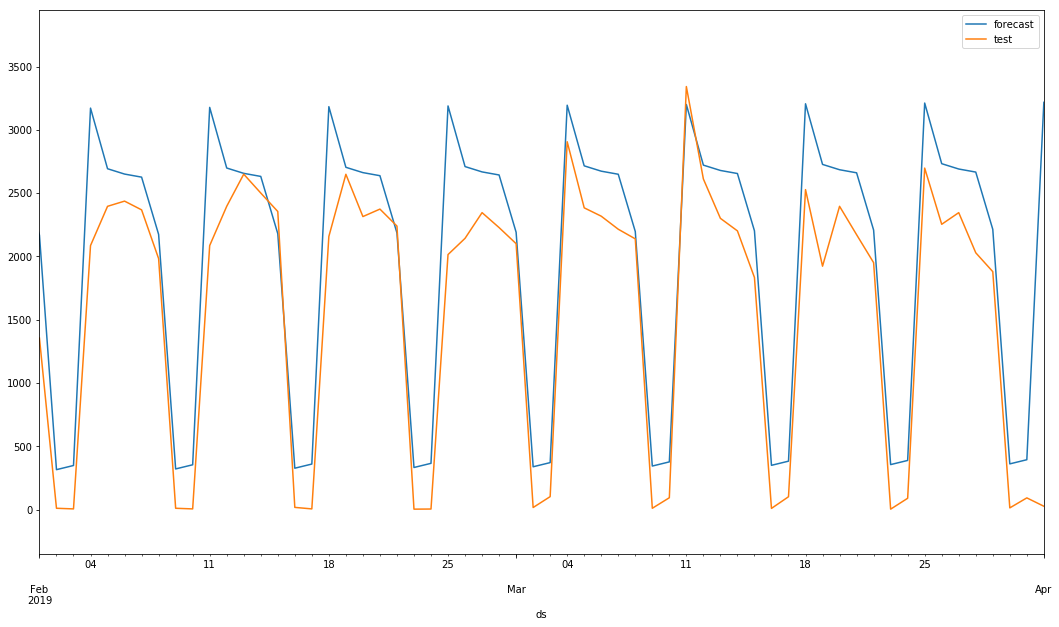

In [25]:
pd.plotting.register_matplotlib_converters() #Permite utilizar matplotlib después de haber importado Prophet.

ax = df_forecast.plot(x = 'ds',y = 'yhat',label = 'forecast',legend = True,figsize = (18,10));

df_test.plot(x = 'ds',y = 'y',
             label = 'test',
             legend = True,
             ax = ax,
             xlim = (pd.Timestamp('2019-02-01'),pd.Timestamp('2019-04-01')));

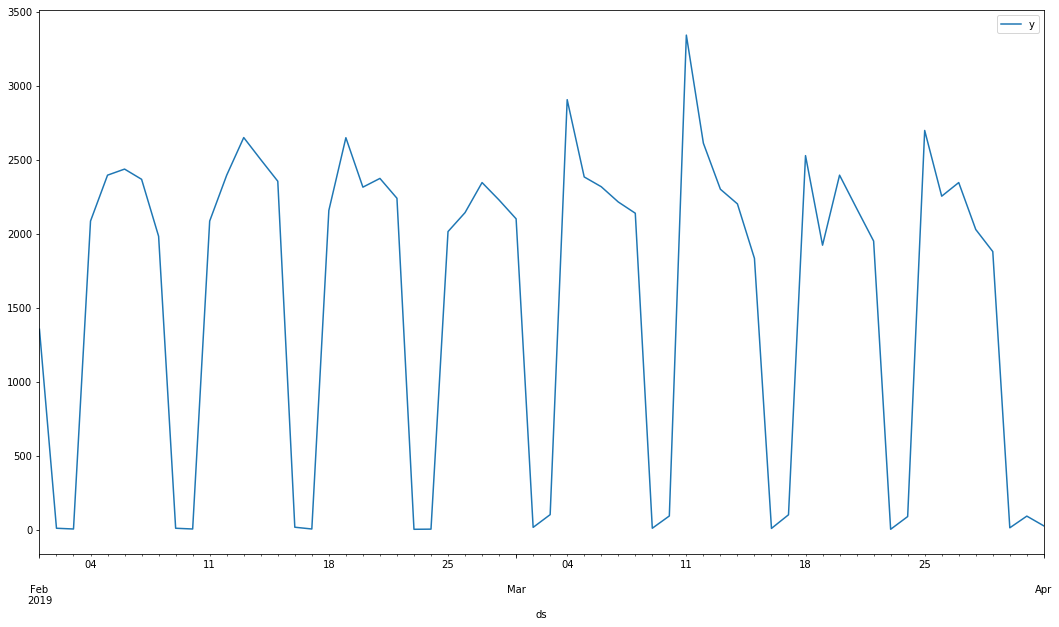

In [26]:
df_test.plot(x = 'ds',y = 'y',figsize = (18,10));

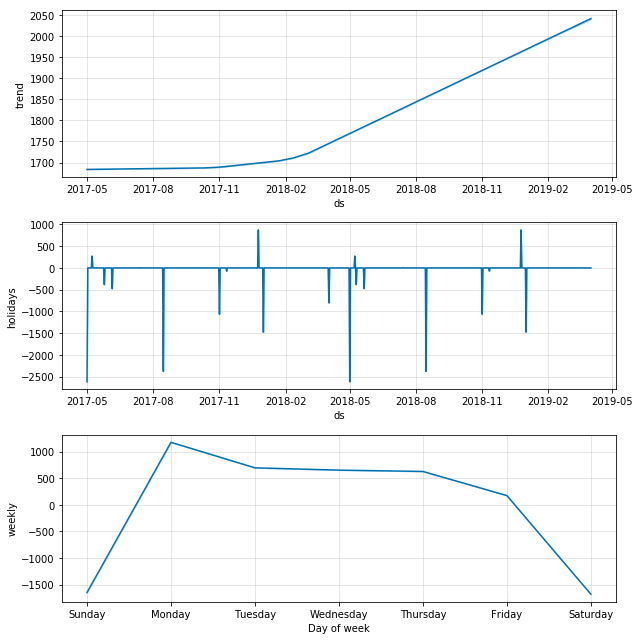

In [27]:
f.plot_components(df_forecast);

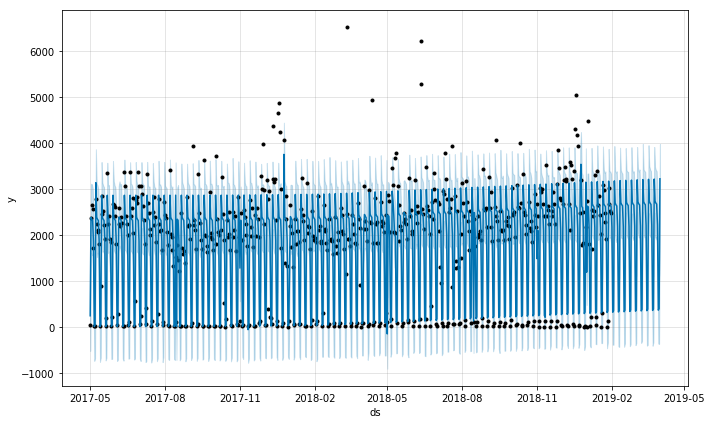

In [28]:
f.plot(df_forecast);

## 4. <a id='rmse'>RMSE</a>

In [29]:
predictions = df_forecast.iloc[-60:]['yhat']

predictions.head()

641    2168.483055
642     315.975652
643     348.805007
644    3171.675777
645    2692.786722
Name: yhat, dtype: float64

In [30]:
rmse(predictions,df_test['y'])

610.2464236730962

## 4. <a id='conclusiones'>Conclusiones</a>